# Malaria Detector

### By Ali Shannon

In this module, I am creating a Malaria detector that uses 27,558 cell images. The dataset is povided by [NIH](https://ceb.nlm.nih.gov/repositories/malaria-datasets/) and made available on [Kaggle](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria).

---

I will be using Convolutional Neural Networks so I will need a minimal amount of preprocessing. 

First, I will resize the images to 92x92 pixels then store them into numpy arrays of 92x92x3 (for RGB)

Second, I will pass them into a custom network design that has the following configuration:

1. 3x3x3 and 5x5x3 kernels convolutional layers with pooling layers, batch normalizations, and dropouts in between.

2. Two fully connected layers with L2 regularizations.

3. All activations are set to ELU except for the output which uses sigmoid for probability


In [1]:
%matplotlib inline

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import glob, os

np.random.seed(42) # uniform output across runs

tf.logging.set_verbosity(tf.logging.INFO) #turn off annoying error messages

In [2]:
classes = np.array(os.listdir('./'), dtype = 'O')
idx = np.argwhere([classes == '.ipynb_checkpoints', classes == 'Malaria.ipynb'])
classes = np.delete(classes, idx)

In [3]:
images = []; filenames = []

for cl in classes:
    for file in glob.glob('{}/*.png'.format(cl)): # import all png images from folder 
        im = Image.open(file) 
        filenames.append(im.filename) # label images
        im = im.resize((92,92)) # resize all images
        images.append(im) # store images

In [4]:
X = np.array([np.array(image) for image in images])

labels = []

for file in filenames:
    for class_name in classes:
        if class_name in file:
            labels.append(class_name)

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder().fit(labels)

y = encoder.transform(labels)

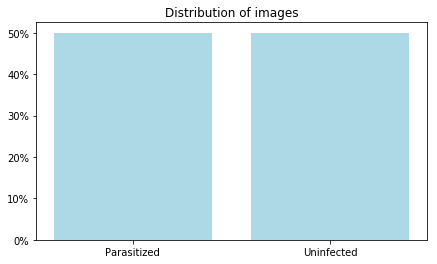

In [6]:
unique_vals, counts = np.unique(labels, return_counts = True)

plt.figure(figsize = (7,4))
plt.bar(unique_vals, counts/counts.sum(), color = 'LightBlue');
vals = np.arange(0, 0.52, 0.1)
plt.yticks(vals, ["{:,.0%}".format(x) for x in vals])
plt.title('Distribution of images')
plt.show()

Knowing that the dataset is balanced, there is no need to do undersampling.

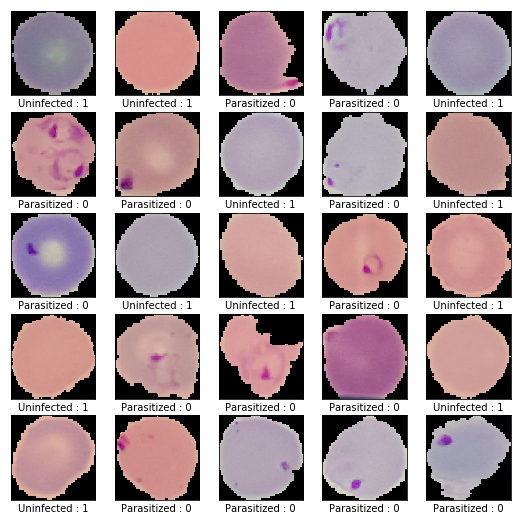

In [7]:
plt.figure(figsize=(9,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = np.random.randint(len(X))
    plt.imshow(X[j], cmap=plt.cm.binary)
    plt.xlabel(labels[j] + ' : ' + str(y[j]))
plt.show()

**Normalize all images**

This will simply normalize each image to make the processing a bit simpler.

$$\hat{u}=\frac{\vec{u}}{\|u \|}$$

In [8]:
X_norm = keras.utils.normalize(X)

Split into training and testing.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.33, random_state=42)

This is where the magic happens. With the help of Karas we can easily construct a simple CNN that can be easily configured by tweaking some of the parameters below.

In [10]:
shapes = (92, 92, 3) # input shapes of all images

l2_regularizer = keras.regularizers.l2(0.001) # penalty

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5, 5), activation='elu', input_shape=shapes),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(rate = 0.25), 
    keras.layers.Conv2D(32, kernel_size=(5, 5), activation='elu'),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(rate = 0.25),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='elu'),
    keras.layers.AveragePooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dropout(rate = 0.15),
    keras.layers.Flatten(),    
    keras.layers.Dense(128, activation = 'elu', kernel_regularizer = l2_regularizer),
    keras.layers.Dense(32, activation = 'elu', kernel_regularizer = l2_regularizer),
    keras.layers.BatchNormalization(axis = 1),
    keras.layers.Dense(1, activation= 'sigmoid')
])
model.compile(optimizer= 'adam',
            loss='binary_crossentropy',
            metrics=['binary_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 15, batch_size= 100)

Train on 18463 samples, validate on 9095 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
18463/18463 [==============================] - 41s 2ms/sample - loss: 0.8848 - binary_accuracy: 0.6580 - val_loss: 0.8906 - val_binary_accuracy: 0.5636
Epoch 2/15
18463/18463 [==============================] - 31s 2ms/sample - loss: 0.5256 - binary_accuracy: 0.8451 - val_loss: 0.6030 - val_binary_accuracy: 0.8288
Epoch 3/15
18463/18463 [==============================] - 30s 2ms/sample - loss: 0.2861 - binary_accuracy: 0.9354 - val_loss: 0.2466 - val_binary_accuracy: 0.9430
Epoch 4/15
18463/18463 [==============================] - 31s 2ms/sample - loss: 0.2226 - binary_accuracy: 0.9492 - val_loss: 0.2471 - val_binary_accuracy: 0.9487
Epoch 5/15
18463/18463 [==============================] - 31s 2ms/sample - loss: 0.1965 - binary_accuracy: 0.9517 - val_loss: 0.1769 - val_binary_accuracy: 0.9612
Epoch 6/15
18463/18463 [==============================] - 30s 2ms/sample - loss: 0.1831 

In [12]:
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)

9095/9095 [==============================] - 6s 667us/sample - loss: 0.1624 - binary_accuracy: 0.9579


Display the 2x2 confusion matrix.

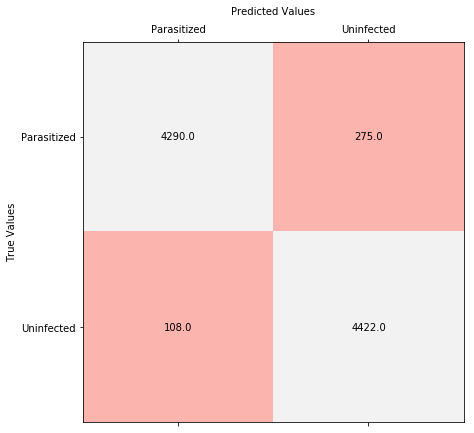

In [13]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, [np.round(v) for v in y_pred])

fig, ax = plt.subplots(figsize = (7,7))
ax.matshow(conf, cmap='Pastel1')

ax.set_ylabel('True Values')
ax.set_xlabel('Predicted Values', labelpad = 10)
ax.xaxis.set_label_position('top') 



ax.set_yticks(range(len(classes)))
ax.set_xticks(range(len(classes)))
ax.set_yticklabels(encoder.classes_)
ax.set_xticklabels(encoder.classes_)


for (i, j), z in np.ndenumerate(conf):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

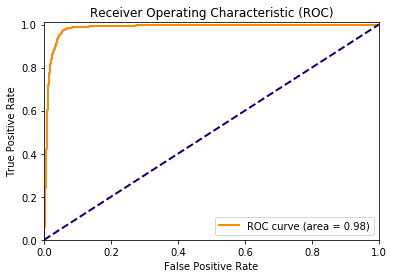

Precision = 0.975443383356071
Recall = 0.9397590361445783


In [15]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print('Precision =', conf[0][0]/(conf[0][0]+conf[1][0]))
print('Recall =', conf[0][0]/(conf[0][0]+conf[0][1]))

This model optimizes precision, which means it produces less false positives. However, for Malaria detection, we might benefit more from recall which is essentially the measure of sensitivity of our model.